<a href="https://colab.research.google.com/github/KGuzikowski/evolutionary_algorithms_uwr/blob/main/L1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import urllib.request
import tqdm

%matplotlib inline

# Task 1

## Simulated Annealing Demo

Skrypt przedstawia przykładową implementację algorytmu symulowanego wyżarzania (ang. Simulated Annealing, SA) i jego zastosowanie do rozwiązywania problemu Quadratic Assignment Problem (QAP). Problem jest dokładnie opisany m.in. w pracy Burkarda i innych [1]. Popularne instancje problemu QAP można znaleźć w bibliotece QAPLib [2]. Skrypt skupia się na rozwiązywaniu instancji NUG12 [3], w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu.

Literatura:

[1]  Burkard, R., Cela, E., Pardalos, P., Pitsoulis, L., "The Quadratic Assignment Problem", http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.217.1914

[2] QAPLIB, http://anjos.mgi.polymtl.ca/qaplib/

[3] NUG12, http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat

In [2]:
QAP_INSTANCE_URL = 'http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat'

## Reading input data

In [3]:
qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

line = qap_instance_file.readline()
n = int(line.decode()[:-1].split()[0])
print('Problem size: %d' % n)

A = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    A[i, :] = list(map(int, line.decode()[:-1].split()))
print('Flow matrix:\n', A)

B = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    B[i, :] = list(map(int, line.decode()[:-1].split()))
print('Distance matrix:\n', B)

HTTPError: ignored

## Objective function

In [ ]:
def qap_objective_function(p):
    s = 0.0
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [ ]:
p = [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]
print(qap_objective_function(p), p)

578.0 [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]


## Random Sampling

In [ ]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = qap_objective_function(permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(qap_objective_function(p), p)

62.258999824523926
604.0 [ 7  6 11  0  3 10  8  2  4  5  9  1]


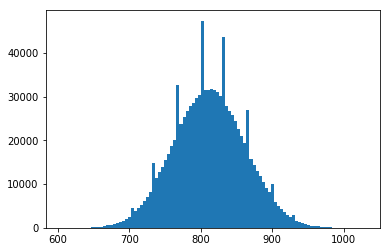

811.921768 49.7013396173


In [ ]:
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

## Simulated Annealing

In [ ]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [ ]:
T = 500000
radius = 1
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min())

45.28400015830994 578.0


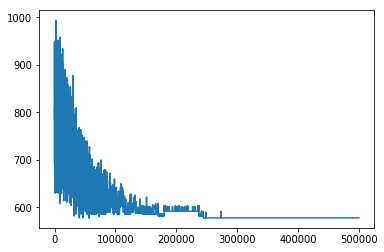

In [ ]:
plt.figure()
plt.plot(costs)
plt.show()

# Task 2

## PBIL implementation

In [224]:
from numpy.random import default_rng
rng = default_rng()

def binary_random(p):
    if rng.uniform() < p:
        return 1
    else:
        return 0

def random_individual(p, d):
    v = []
    for i in range(d):
        v.append(binary_random(p[i]))
    
    return v

def random_population(p, N, d):
    P = []
    for _ in range(N):
        P.append(random_individual(p, d))

    return np.array(P)

def population_evaluation(target, population, d, N, score_func, k=None):
    target_score = score_func(target)
    scores = np.array(list(map(score_func, population)))

    # score = 0

    # for i in range(N):
    #     diff = np.abs(target_score - scores[i])
    #     score += (d - diff) / d

    # return score / N
    correct = 0

    for score in scores:
        if score == target_score:
            correct += 1

    return correct / N

def termination_condition(score):
    return score >= 0.80

def get_best_individual(target, population, N, score_func, k=None):
    target_score = score_func(target)
    scores = np.array(list(map(score_func, population)))
    min = np.inf
    best = None

    for i in range(N):
        if scores[i] == target_score:
            return population[i]
        diff = np.abs(target_score - scores[i])
        if diff < min:
            min = diff
            best = population[i]
    
    return best

def PBIL(target, d, N, lr, mutation_ppb, mutation_dist, score_func, k=None):
    """
    d - chromosome size
    N - population size
    """
    p = np.full(d, 0.5, dtype=np.float32)
    population = random_population(p, N, d)

    population_score = population_evaluation(target, population, d, N, score_func, k)
    # print('population_score', population_score)
    steps = 0
    while not termination_condition(population_score):
        # print('population_score', population_score)
        best_individual = get_best_individual(target, population, N, score_func, k)
        # print('best_individual', best_individual)

        for i in range(d):
            p[i] = p[i]*(1 - lr) + best_individual[i]*lr

        for i in range(d):
            if rng.uniform() < mutation_ppb:
                p[i] = p[i]*(1 - mutation_dist) + binary_random(0.5)*mutation_dist

        population = random_population(p, N, d)
        population_score = population_evaluation(target, population, d, N, score_func, k)
        steps += 1
    # print('population_score', population_score)

    return get_best_individual(target, population, N, score_func), population_score, steps

In [225]:
def OneMax(p):
    return p.sum()

def DeceptiveOneMax(p):
    if np.all((p == 0)):
        return p.shape[0] + 1
    return p.sum()

def KDeceptiveOneMax(p, k=2):
    sum = 0
    i = 0

    while i < p.shape[0]:
        sum += DeceptiveOneMax(p[i:i+k])
        i = i+k

    return sum

In [221]:
from itertools import product
from time import time

N_l = [3, 4, 5, 6, 8]
lr_l = [0.01, 0.05, 0.1, 0.5]
mutation_ppb_l = [0.01, 0.05, 0.1, 0.5]
mutation_dist_l = [0.01, 0.05, 0.1, 0.5]
score_func_l = [OneMax, DeceptiveOneMax, KDeceptiveOneMax]
k_l = [2, 4, 6]

ones = 8
zeros = 4
target = np.array([1] * ones + [0] * zeros)
np.random.shuffle(target)
target
results = []

start = time()

for N, lr, mutation_ppb, mutation_dist, score_func in product(N_l, lr_l, mutation_ppb_l, mutation_dist_l, score_func_l):
    if score_func.__name__ == 'KDeceptiveOneMax':
        for k in k_l:
            res, population_score, steps = PBIL(target, target.shape[0], N, lr, mutation_ppb, mutation_dist, score_func, k)
            results.append({
                'N': N,
                'lr': lr,
                'mutation_ppb': mutation_ppb,
                'mutation_dist': mutation_dist,
                'score_func': score_func.__name__,
                'k': k,
                'population_score': population_score,
                'steps': steps,
                'result': res,

            })
    else:
        res, population_score, steps = PBIL(target, target.shape[0], N, lr, mutation_ppb, mutation_dist, score_func)
        results.append({
            'N': N,
            'lr': lr,
            'mutation_ppb': mutation_ppb,
            'mutation_dist': mutation_dist,
            'score_func': score_func.__name__,
            'k': None,
            'population_score': population_score,
            'steps': steps,
            'result': res,
        })

end = time()
print("It took", end - start)

It took 9460.51943731308


In [227]:
df = pd.DataFrame(results)
df

,N,lr,mutation_ppb,mutation_dist,score_func,k,population_score,steps,result
0,3,0.01,0.01,0.01,OneMax,NaN,1.000,80,"[0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]"
1,3,0.01,0.01,0.01,DeceptiveOneMax,NaN,1.000,47,"[1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1]"
2,3,0.01,0.01,0.01,KDeceptiveOneMax,2.0,1.000,184,"[1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1]"
3,3,0.01,0.01,0.01,KDeceptiveOneMax,4.0,1.000,886,"[0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1]"
4,3,0.01,0.01,0.01,KDeceptiveOneMax,6.0,1.000,282,"[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1]"
...,...,...,...,...,...,...,...,...,...
1595,8,0.50,0.50,0.50,OneMax,NaN,0.875,377,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]"
1596,8,0.50,0.50,0.50,DeceptiveOneMax,NaN,0.875,77,"[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]"
1597,8,0.50,0.50,0.50,KDeceptiveOneMax,2.0,0.875,1455,"[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0]"
1598,8,0.50,0.50,0.50,KDeceptiveOneMax,4.0,0.875,596,"[0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0]"


In [228]:
df.sort_values(by=['population_score', 'steps'])

,N,lr,mutation_ppb,mutation_dist,score_func,k,population_score,steps,result
800,5,0.10,0.01,0.01,OneMax,NaN,0.8,2,"[1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1]"
896,5,0.50,0.01,0.50,DeceptiveOneMax,NaN,0.8,2,"[1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1]"
914,5,0.50,0.05,0.10,KDeceptiveOneMax,6.0,0.8,2,"[0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]"
887,5,0.50,0.01,0.05,KDeceptiveOneMax,2.0,0.8,3,"[1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1]"
901,5,0.50,0.05,0.01,DeceptiveOneMax,NaN,0.8,3,"[1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1]"
...,...,...,...,...,...,...,...,...,...
373,4,0.01,0.10,0.10,KDeceptiveOneMax,4.0,1.0,9192,"[1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0]"
392,4,0.01,0.50,0.10,KDeceptiveOneMax,2.0,1.0,9463,"[1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]"
1419,8,0.05,0.10,0.50,KDeceptiveOneMax,6.0,1.0,10794,"[0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1]"
369,4,0.01,0.10,0.05,KDeceptiveOneMax,6.0,1.0,13460,"[0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]"
